In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import time
from datetime import datetime
import networkx as nx
import torch
import torch.optim as optim
import numpy as np
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
import torch_geometric.transforms as T
from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNStack, self).__init__()
        self.task = task
        self.convs = nn.ModuleList()
        
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))
            
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25),
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')
            
        self.dropout = 0.25
        self.num_layers = 3
        
    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                               nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
            x = torch.ones(data.num_nodes, 1)
            
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            
        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)
            
        x = self.post_mp(x)
        
        return emb, F.log_softmax(x, dim=1)
    
    def loss(self, pred, label):
        return F.nll_loss(pred, label)
        

In [3]:
# DIY method put into GNNStack
class CustomConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomConv, self).__init__(aggr='add') # "add" aggregation
        self.lin = nn.Linear(in_channels, out_channels)
        
    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        
        # Add self-loops to the adjacency matrix.
        edge_index, _ = pyg_utils.add_self_loops(edg_index, num_nodes=x.size(0))
        
        #Transform node feature matrix.
        x = self.lin(x)
        
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)
    
    def message(self, x_j, edge_index, size):
        # Compute messages
        # x_j has shape[E, out_channels]
        
        row, col = edge_index
        deg = pyg_utils.degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        return norm.veiw(-1, 1) * x_j
    
    def update(self, aggr_out):
        #aggr_out has shape [N, out_channels]
        
        return aggr_out

In [4]:
def train(dataset, task, writer):
    if task == 'graph':
        data_size = len(dataset)
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
    else:
        test_loader = loader = DataLoader(dataset, batch_size=64, shuffle=True)
        
    # build model
    model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
    opt= optim.Adam(model.parameters(), lr=0.01)
    
    # train
    for epoch in range(200):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            embedding, pred = model(batch)
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        #tensorboard
        writer.add_scalar("loss", total_loss, epoch)
        
        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch  {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, test_acc))
            
            writer.add_scalar("test accuracy", test_acc, epoch)
            
    return model

In [5]:
def test(loader, model, is_validation=False):
    # Keeping BatchNormalization and Dropout
    model.eval()
    
    correct = 0
    for data in loader:
        with torch.no_grad():
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y
            
        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask
            # node classificaion: only evaluate on nodes in test set
            pred = pred[mask]
            label = data.y[mask]
            
        correct += pred.eq(label).sum().item()
        
    if model.task == 'graph':
        total = len(loader.dataset)
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item()
    return correct / total
            

In [6]:
#IMDB-BINARY is a movie collaboration dataset that consists of the ego-networks of 1,000 actors/actresses
#who played roles in movies in IMDB. In each graph, nodes represent actors/actress, 
#and there is an edge between them if they appear in the same movie. These graphs are derived from the Action and Romance genres.
writer = SummaryWriter("./log98/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
dataset = TUDataset(root='/tmp/IMDB-BINARY', name='IMDB-BINARY')
dataset = dataset.shuffle()
task = 'graph'
model = train(dataset, task, writer)

Epoch  0. Loss: 1.2921. Test accuracy: 0.4950
Epoch  10. Loss: 0.6326. Test accuracy: 0.6250
Epoch  20. Loss: 0.5900. Test accuracy: 0.7050
Epoch  30. Loss: 0.6202. Test accuracy: 0.6700
Epoch  40. Loss: 0.5758. Test accuracy: 0.7000
Epoch  50. Loss: 0.5886. Test accuracy: 0.6700
Epoch  60. Loss: 0.5845. Test accuracy: 0.7000
Epoch  70. Loss: 0.5806. Test accuracy: 0.7000
Epoch  80. Loss: 0.5813. Test accuracy: 0.6900
Epoch  90. Loss: 0.5586. Test accuracy: 0.6850
Epoch  100. Loss: 0.5787. Test accuracy: 0.7050
Epoch  110. Loss: 0.5854. Test accuracy: 0.6900
Epoch  120. Loss: 0.5744. Test accuracy: 0.6900
Epoch  130. Loss: 0.5724. Test accuracy: 0.6850
Epoch  140. Loss: 0.5997. Test accuracy: 0.6750
Epoch  150. Loss: 0.5506. Test accuracy: 0.7000
Epoch  160. Loss: 0.5755. Test accuracy: 0.7050
Epoch  170. Loss: 0.5717. Test accuracy: 0.6900
Epoch  180. Loss: 0.5692. Test accuracy: 0.7150
Epoch  190. Loss: 0.5610. Test accuracy: 0.7000


In [ ]:
#cmd
#tensorboard --logdir=./path/to/the/folder --port 8123

In [6]:
#CiteSeer数据集包括3312种科学出版物，分为6类。. 引文网络由4732条链接组成。. 
#数据集中的每个发布都由一个0/1值的单词向量来描述，该向量表示字典中相应单词的存在或不存在。.
#该词典由3703个独特的单词组成。. 数据集中的自述文件提供了更多的细节。. CiteSeer for Entity Resolution.
#为了实体解析，CiteSeer数据集包含1504个机器学习文档，其中2892个作者引用了165个作者实体。. 
#对于这个数据集，惟一可用的属性信息是作者名。. 完整的姓总是给出的，在某些情况下，作者的全名和中间名是给出的，其他时候只给出首字母。
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
dataset = Planetoid(root='/tmp/citeseer', name='citeseer')

task = 'node'
model = train(dataset, task, writer)

Epoch  0. Loss: 1.7875. Test accuracy: 0.1080
Epoch  10. Loss: 0.4636. Test accuracy: 0.6240
Epoch  20. Loss: 0.1152. Test accuracy: 0.6560
Epoch  30. Loss: 0.0866. Test accuracy: 0.6290
Epoch  40. Loss: 0.1160. Test accuracy: 0.6310
Epoch  50. Loss: 0.0274. Test accuracy: 0.6230
Epoch  60. Loss: 0.0071. Test accuracy: 0.6140
Epoch  70. Loss: 0.0409. Test accuracy: 0.6170
Epoch  80. Loss: 0.0035. Test accuracy: 0.6240
Epoch  90. Loss: 0.0011. Test accuracy: 0.5870
Epoch  100. Loss: 0.0012. Test accuracy: 0.6160
Epoch  110. Loss: 0.0433. Test accuracy: 0.6090
Epoch  120. Loss: 0.0090. Test accuracy: 0.6200
Epoch  130. Loss: 0.0046. Test accuracy: 0.6220
Epoch  140. Loss: 0.0073. Test accuracy: 0.6300
Epoch  150. Loss: 0.0016. Test accuracy: 0.6270
Epoch  160. Loss: 0.0155. Test accuracy: 0.6050
Epoch  170. Loss: 0.0083. Test accuracy: 0.6150
Epoch  180. Loss: 0.0104. Test accuracy: 0.6160
Epoch  190. Loss: 0.0037. Test accuracy: 0.6090


In [8]:
dataset[0]

Data(edge_index=[2, 9104], test_mask=[3327], train_mask=[3327], val_mask=[3327], x=[3327, 3703], y=[3327])

In [6]:
#The Cora dataset consists of 2708 scientific publications calssified into 
#one of sevenclasses. The citation network consists of 5429 links. 
#Each publication in the dataset is described by a 0/1-valued word vector indicating
#the absence/presence of the corresponding word from the dictionary. The dictionary
#consists of 1433 unique words.
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
dataset = dataset = Planetoid(root='/tmp/cora', name='cora')

task = 'node'
model = train(dataset, task, writer)

Epoch  0. Loss: 1.9521. Test accuracy: 0.2530
Epoch  10. Loss: 0.9066. Test accuracy: 0.7470
Epoch  20. Loss: 0.2254. Test accuracy: 0.7810
Epoch  30. Loss: 0.0989. Test accuracy: 0.7450
Epoch  40. Loss: 0.0462. Test accuracy: 0.7760
Epoch  50. Loss: 0.0335. Test accuracy: 0.7470
Epoch  60. Loss: 0.0244. Test accuracy: 0.7740
Epoch  70. Loss: 0.0198. Test accuracy: 0.7510
Epoch  80. Loss: 0.0009. Test accuracy: 0.7610
Epoch  90. Loss: 0.0089. Test accuracy: 0.7510
Epoch  100. Loss: 0.0114. Test accuracy: 0.7540
Epoch  110. Loss: 0.0296. Test accuracy: 0.7540
Epoch  120. Loss: 0.0137. Test accuracy: 0.7590
Epoch  130. Loss: 0.0195. Test accuracy: 0.7640
Epoch  140. Loss: 0.0099. Test accuracy: 0.7680
Epoch  150. Loss: 0.0075. Test accuracy: 0.7650
Epoch  160. Loss: 0.0027. Test accuracy: 0.7570
Epoch  170. Loss: 0.0131. Test accuracy: 0.7540
Epoch  180. Loss: 0.0030. Test accuracy: 0.7470
Epoch  190. Loss: 0.0046. Test accuracy: 0.7710


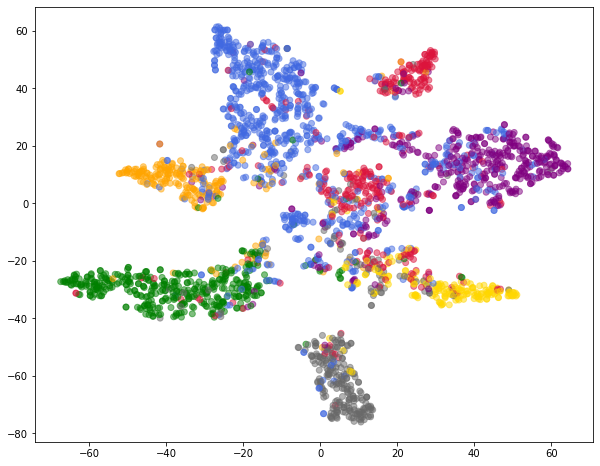

In [7]:
color_list = ["crimson", "orange", "green", "royalblue", "purple", "dimgrey", "gold"]

loader = DataLoader(dataset, batch_size=64, shuffle=True)
embs = []
colors = []
for batch in loader:
    emb, pred = model(batch)
    embs.append(emb)
    colors += [color_list[y] for y in batch.y]
embs = torch.cat(embs, dim=0)

xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))

plt.figure(figsize=(10, 8))
plt.scatter(xs, ys, color=colors, alpha=0.5)

In [1]:
import pickle 